# Pure‑Python Candlestick Scanner + Backtester (Swing Trading)

This notebook **does not use TA-Lib**. All candlestick detections and indicators are implemented in **pure Python** with `pandas`/`numpy`.

**What you get**
- Scanner for classic candlestick patterns (Daily or 4H), with `recent_window` and **trend-at-signal** filters.
- Backtester with **ATR(14)** (Wilder), next‑bar‑open entries, **ATR stops/targets**, fees, slippage, time stop, and position sizing in **shares (qty)**.
- Trade log includes: `symbol`, `signal_time`, `pattern`, `entry_time`, `exit_time`, `side`, `qty`, `entry_price`, `exit_price`, `reason`, `bars`, `gross_ret_pct`, `pnl`, `equity_after`.

> Note: Pattern rules here are **reasonable approximations** of textbook definitions and may differ slightly from TA‑Lib thresholds.


## 1) Setup
If you don't have `yfinance` yet, this cell will try to install it.


In [1]:
import sys, subprocess, importlib

def ensure(pkg, pip_name=None):
    try:
        importlib.import_module(pkg)
        print(f"OK: {pkg}")
    except ImportError:
        name = pip_name or pkg
        print(f"Installing {name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", name])

for p in ["yfinance", "pandas", "numpy", "matplotlib"]:
    ensure(p)

import pandas as pd
import numpy as np
import yfinance as yf
import math
import json
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 160)

OK: yfinance
OK: pandas
OK: numpy
OK: matplotlib


## 2) Parameters

In [2]:
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# SYMBOLS & TIMEFRAME
symbols = ['360ONE.NS', '3MINDIA.NS', 'ABB.NS', 'ACC.NS', 'ACMESOLAR.NS', 'AIAENG.NS', 'APLAPOLLO.NS', 'AUBANK.NS', 'AWL.NS', 'AADHARHFC.NS', 'AARTIIND.NS', 'AAVAS.NS', 'ABBOTINDIA.NS', 'ACE.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIPOWER.NS', 'ATGL.NS', 'ABCAPITAL.NS', 'ABFRL.NS', 'ABREL.NS', 'ABSLAMC.NS', 'AEGISLOG.NS', 'AFCONS.NS', 'AFFLE.NS', 'AJANTPHARM.NS', 'AKUMS.NS', 'APLLTD.NS', 'ALIVUS.NS', 'ALKEM.NS', 'ALKYLAMINE.NS', 'ALOKINDS.NS', 'ARE&M.NS', 'AMBER.NS', 'AMBUJACEM.NS', 'ANANDRATHI.NS', 'ANANTRAJ.NS', 'ANGELONE.NS', 'APARINDS.NS', 'APOLLOHOSP.NS', 'APOLLOTYRE.NS', 'APTUS.NS', 'ASAHIINDIA.NS', 'ASHOKLEY.NS', 'ASIANPAINT.NS', 'ASTERDM.NS', 'ASTRAZEN.NS', 'ASTRAL.NS', 'ATUL.NS', 'AUROPHARMA.NS', 'AIIL.NS', 'DMART.NS', 'AXISBANK.NS', 'BASF.NS', 'BEML.NS', 'BLS.NS', 'BSE.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS', 'BAJAJHFL.NS', 'BALKRISIND.NS', 'BALRAMCHIN.NS', 'BANDHANBNK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'MAHABANK.NS', 'BATAINDIA.NS', 'BAYERCROP.NS', 'BERGEPAINT.NS', 'BDL.NS', 'BEL.NS', 'BHARATFORG.NS', 'BHEL.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BHARTIHEXA.NS', 'BIKAJI.NS', 'BIOCON.NS', 'BSOFT.NS', 'BLUEDART.NS', 'BLUESTARCO.NS', 'BBTC.NS', 'BOSCHLTD.NS', 'FIRSTCRY.NS', 'BRIGADE.NS', 'BRITANNIA.NS', 'MAPMYINDIA.NS', 'CCL.NS', 'CESC.NS', 'CGPOWER.NS', 'CRISIL.NS', 'CAMPUS.NS', 'CANFINHOME.NS', 'CANBK.NS', 'CAPLIPOINT.NS', 'CGCL.NS', 'CARBORUNIV.NS', 'CASTROLIND.NS', 'CEATLTD.NS', 'CENTRALBK.NS', 'CDSL.NS', 'CENTURYPLY.NS', 'CERA.NS', 'CHALET.NS', 'CHAMBLFERT.NS', 'CHENNPETRO.NS', 'CHOLAHLDNG.NS', 'CHOLAFIN.NS', 'CIPLA.NS', 'CUB.NS', 'CLEAN.NS', 'COALINDIA.NS', 'COCHINSHIP.NS', 'COFORGE.NS', 'COHANCE.NS', 'COLPAL.NS', 'CAMS.NS', 'CONCORDBIO.NS', 'CONCOR.NS', 'COROMANDEL.NS', 'CRAFTSMAN.NS', 'CREDITACC.NS', 'CROMPTON.NS', 'CUMMINSIND.NS', 'CYIENT.NS', 'DCMSHRIRAM.NS', 'DLF.NS', 'DOMS.NS', 'DABUR.NS', 'DALBHARAT.NS', 'DATAPATTNS.NS', 'DEEPAKFERT.NS', 'DEEPAKNTR.NS', 'DELHIVERY.NS', 'DEVYANI.NS', 'DIVISLAB.NS', 'DIXON.NS', 'LALPATHLAB.NS', 'DRREDDY.NS', 'EIDPARRY.NS', 'EIHOTEL.NS', 'EICHERMOT.NS', 'ELECON.NS', 'ELGIEQUIP.NS', 'EMAMILTD.NS', 'EMCURE.NS', 'ENDURANCE.NS', 'ENGINERSIN.NS', 'ERIS.NS', 'ESCORTS.NS', 'ETERNAL.NS', 'EXIDEIND.NS', 'NYKAA.NS', 'FEDERALBNK.NS', 'FACT.NS', 'FINCABLES.NS', 'FINPIPE.NS', 'FSL.NS', 'FIVESTAR.NS', 'FORTIS.NS', 'GAIL.NS', 'GVT&D.NS', 'GMRAIRPORT.NS', 'GRSE.NS', 'GICRE.NS', 'GILLETTE.NS', 'GLAND.NS', 'GLAXO.NS', 'GLENMARK.NS', 'MEDANTA.NS', 'GODIGIT.NS', 'GPIL.NS', 'GODFRYPHLP.NS', 'GODREJAGRO.NS', 'GODREJCP.NS', 'GODREJIND.NS', 'GODREJPROP.NS', 'GRANULES.NS', 'GRAPHITE.NS', 'GRASIM.NS', 'GRAVITA.NS', 'GESHIP.NS', 'FLUOROCHEM.NS', 'GUJGASLTD.NS', 'GMDCLTD.NS', 'GNFC.NS', 'GPPL.NS', 'GSPL.NS', 'HEG.NS', 'HBLENGINE.NS', 'HCLTECH.NS', 'HDFCAMC.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HFCL.NS', 'HAPPSTMNDS.NS', 'HAVELLS.NS', 'HEROMOTOCO.NS', 'HSCL.NS', 'HINDALCO.NS', 'HAL.NS', 'HINDCOPPER.NS', 'HINDPETRO.NS', 'HINDUNILVR.NS', 'HINDZINC.NS', 'POWERINDIA.NS', 'HOMEFIRST.NS', 'HONASA.NS', 'HONAUT.NS', 'HUDCO.NS', 'HYUNDAI.NS', 'ICICIBANK.NS', 'ICICIGI.NS', 'ICICIPRULI.NS', 'IDBI.NS', 'IDFCFIRSTB.NS', 'IFCI.NS', 'IIFL.NS', 'INOXINDIA.NS', 'IRB.NS', 'IRCON.NS', 'ITC.NS', 'ITI.NS', 'INDGN.NS', 'INDIACEM.NS', 'INDIAMART.NS', 'INDIANB.NS', 'IEX.NS', 'INDHOTEL.NS', 'IOC.NS', 'IOB.NS', 'IRCTC.NS', 'IRFC.NS', 'IREDA.NS', 'IGL.NS', 'INDUSTOWER.NS', 'INDUSINDBK.NS', 'NAUKRI.NS', 'INFY.NS', 'INOXWIND.NS', 'INTELLECT.NS', 'INDIGO.NS', 'IGIL.NS', 'IKS.NS', 'IPCALAB.NS', 'JBCHEPHARM.NS', 'JKCEMENT.NS', 'JBMA.NS', 'JKTYRE.NS', 'JMFINANCIL.NS', 'JSWENERGY.NS', 'JSWHL.NS', 'JSWINFRA.NS', 'JSWSTEEL.NS', 'JPPOWER.NS', 'J&KBANK.NS', 'JINDALSAW.NS', 'JSL.NS', 'JINDALSTEL.NS', 'JIOFIN.NS', 'JUBLFOOD.NS', 'JUBLINGREA.NS', 'JUBLPHARMA.NS', 'JWL.NS', 'JUSTDIAL.NS', 'JYOTHYLAB.NS', 'JYOTICNC.NS', 'KPRMILL.NS', 'KEI.NS', 'KNRCON.NS', 'KPITTECH.NS', 'KAJARIACER.NS', 'KPIL.NS', 'KALYANKJIL.NS', 'KANSAINER.NS', 'KARURVYSYA.NS', 'KAYNES.NS', 'KEC.NS', 'KFINTECH.NS', 'KIRLOSBROS.NS', 'KIRLOSENG.NS', 'KOTAKBANK.NS', 'KIMS.NS', 'LTF.NS', 'LTTS.NS', 'LICHSGFIN.NS', 'LTFOODS.NS', 'LTIM.NS', 'LT.NS', 'LATENTVIEW.NS', 'LAURUSLABS.NS', 'LEMONTREE.NS', 'LICI.NS', 'LINDEINDIA.NS', 'LLOYDSME.NS', 'LODHA.NS', 'LUPIN.NS', 'MMTC.NS', 'MRF.NS', 'MGL.NS', 'MAHSEAMLES.NS', 'M&MFIN.NS', 'M&M.NS', 'MANAPPURAM.NS', 'MRPL.NS', 'MANKIND.NS', 'MARICO.NS', 'MARUTI.NS', 'MASTEK.NS', 'MFSL.NS', 'MAXHEALTH.NS', 'MAZDOCK.NS', 'METROPOLIS.NS', 'MINDACORP.NS', 'MSUMI.NS', 'MOTILALOFS.NS', 'MPHASIS.NS', 'MCX.NS', 'MUTHOOTFIN.NS', 'NATCOPHARM.NS', 'NBCC.NS', 'NCC.NS', 'NHPC.NS', 'NLCINDIA.NS', 'NMDC.NS', 'NSLNISP.NS', 'NTPCGREEN.NS', 'NTPC.NS', 'NH.NS', 'NATIONALUM.NS', 'NAVA.NS', 'NAVINFLUOR.NS', 'NESTLEIND.NS', 'NETWEB.NS', 'NETWORK18.NS', 'NEULANDLAB.NS', 'NEWGEN.NS', 'NAM-INDIA.NS', 'NIVABUPA.NS', 'NUVAMA.NS', 'OBEROIRLTY.NS', 'ONGC.NS', 'OIL.NS', 'OLAELEC.NS', 'OLECTRA.NS', 'PAYTM.NS', 'OFSS.NS', 'POLICYBZR.NS', 'PCBL.NS', 'PGEL.NS', 'PIIND.NS', 'PNBHOUSING.NS', 'PNCINFRA.NS', 'PTCIL.NS', 'PVRINOX.NS', 'PAGEIND.NS', 'PATANJALI.NS', 'PERSISTENT.NS', 'PETRONET.NS', 'PFIZER.NS', 'PHOENIXLTD.NS', 'PIDILITIND.NS', 'PEL.NS', 'PPLPHARMA.NS', 'POLYMED.NS', 'POLYCAB.NS', 'POONAWALLA.NS', 'PFC.NS', 'POWERGRID.NS', 'PRAJIND.NS', 'PREMIERENE.NS', 'PRESTIGE.NS', 'PNB.NS', 'RRKABEL.NS', 'RBLBANK.NS', 'RECLTD.NS', 'RHIM.NS', 'RITES.NS', 'RADICO.NS', 'RVNL.NS', 'RAILTEL.NS', 'RAINBOW.NS', 'RKFORGE.NS', 'RCF.NS', 'RTNINDIA.NS', 'RAYMONDLSL.NS', 'RAYMOND.NS', 'REDINGTON.NS', 'RELIANCE.NS', 'RPOWER.NS', 'ROUTE.NS', 'SBFC.NS', 'SBICARD.NS', 'SBILIFE.NS', 'SJVN.NS', 'SKFINDIA.NS', 'SRF.NS', 'SAGILITY.NS', 'SAILIFE.NS', 'SAMMAANCAP.NS', 'MOTHERSON.NS', 'SAPPHIRE.NS', 'SARDAEN.NS', 'SAREGAMA.NS', 'SCHAEFFLER.NS', 'SCHNEIDER.NS', 'SCI.NS', 'SHREECEM.NS', 'RENUKA.NS', 'SHRIRAMFIN.NS', 'SHYAMMETL.NS', 'SIEMENS.NS', 'SIGNATURE.NS', 'SOBHA.NS', 'SOLARINDS.NS', 'SONACOMS.NS', 'SONATSOFTW.NS', 'STARHEALTH.NS', 'SBIN.NS', 'SAIL.NS', 'SWSOLAR.NS', 'SUMICHEM.NS', 'SUNPHARMA.NS', 'SUNTV.NS', 'SUNDARMFIN.NS', 'SUNDRMFAST.NS', 'SUPREMEIND.NS', 'SUZLON.NS', 'SWANCORP.NS', 'SWIGGY.NS', 'SYNGENE.NS', 'SYRMA.NS', 'TBOTEK.NS', 'TVSMOTOR.NS', 'TANLA.NS', 'TATACHEM.NS', 'TATACOMM.NS', 'TCS.NS', 'TATACONSUM.NS', 'TATAELXSI.NS', 'TATAINVEST.NS', 'TATAMOTORS.NS', 'TATAPOWER.NS', 'TATASTEEL.NS', 'TATATECH.NS', 'TTML.NS', 'TECHM.NS', 'TECHNOE.NS', 'TEJASNET.NS', 'NIACL.NS', 'RAMCOCEM.NS', 'THERMAX.NS', 'TIMKEN.NS', 'TITAGARH.NS', 'TITAN.NS', 'TORNTPHARM.NS', 'TORNTPOWER.NS', 'TARIL.NS', 'TRENT.NS', 'TRIDENT.NS', 'TRIVENI.NS', 'TRITURBINE.NS', 'TIINDIA.NS', 'UCOBANK.NS', 'UNOMINDA.NS', 'UPL.NS', 'UTIAMC.NS', 'ULTRACEMCO.NS', 'UNIONBANK.NS', 'UBL.NS', 'UNITDSPR.NS', 'USHAMART.NS', 'VGUARD.NS', 'DBREALTY.NS', 'VTL.NS', 'VBL.NS', 'MANYAVAR.NS', 'VEDL.NS', 'VIJAYA.NS', 'VMM.NS', 'IDEA.NS', 'VOLTAS.NS', 'WAAREEENER.NS', 'WELCORP.NS', 'WELSPUNLIV.NS', 'WESTLIFE.NS', 'WHIRLPOOL.NS', 'WIPRO.NS', 'WOCKPHARMA.NS', 'YESBANK.NS', 'ZFCVINDIA.NS', 'ZEEL.NS', 'ZENTEC.NS', 'ZENSARTECH.NS', 'ZYDUSLIFE.NS', 'ECLERX.NS']

timeframe = "1d"              # '1d' (Daily) or '4h' (4-Hour)
lookback_days = 1825          # For daily only (approx 5 years)

# SCANNER
recent_window = 3             # Look for signals in last N candles
use_trend_filter_scanner = True  # Bullish only after downtrend, bearish only after uptrend

# BACKTEST
signal_set = "bullish"        # 'bullish', 'bearish', or 'both'
use_trend_filter_backtest = True
allow_shorts = False          # For equities, default long-only

# ATR risk model
atr_period = 14
atr_sl_mult = 2.0             # Stop distance = SL mult * ATR
atr_tp_mult = 2.0             # Take profit distance = TP mult * ATR

# Portfolio & trading
initial_equity = 100000.0
risk_per_trade_pct = 1.0      # % of per-symbol equity allocated per trade (simple sizing)
fees_bps_per_side = 10.0      # 10 bps = 0.10% per side
slippage_bps_per_side = 5.0   # 5 bps = 0.05% per side
max_holding_bars = 20         # Time stop if neither SL nor TP is hit
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

assert timeframe in ("1d", "4h")
assert signal_set in ("bullish", "bearish", "both")

## 3) Helpers & Indicators (Pure Python)

In [3]:
def yf_params(timeframe: str, lookback_days: int):
    if timeframe == "1d":
        period = f"{min(max(lookback_days, 2), 3650)}d"  # up to 10y
        interval = "1d"
    else:
        period = "60d"   # yfinance intraday reliable max for 4H
        interval = "4h"
    return dict(period=period, interval=interval)

def fetch_ohlc(ticker: str, period: str, interval: str) -> pd.DataFrame:
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=False, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        try:
            df = df.xs(ticker, axis=1, level=1)
        except Exception:
            pass
    df = df.rename(columns={c: c.title() for c in df.columns})
    df = df.dropna()
    return df

def rma(series: pd.Series, period: int) -> pd.Series:
    """Wilder's smoothing (RMA) using EMA alpha=1/period."""
    return series.ewm(alpha=1/period, adjust=False).mean()

def atr_wilder(df: pd.DataFrame, period: int = 14) -> pd.Series:
    high = df['High']; low = df['Low']; close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low).abs(),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    return rma(tr, period)

def series_slope(series: pd.Series, window: int = 5) -> pd.Series:
    # Rolling slope of linear fit across 'window' bars
    return series.rolling(window).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

def in_downtrend_series(df: pd.DataFrame, window: int = 5) -> pd.Series:
    close = df['Close']
    sma20 = close.rolling(20).mean()
    sl = series_slope(close, window)
    return (sl < 0) & (close < sma20)

def in_uptrend_series(df: pd.DataFrame, window: int = 5) -> pd.Series:
    close = df['Close']
    sma20 = close.rolling(20).mean()
    sl = series_slope(close, window)
    return (sl > 0) & (close > sma20)

## 4) Candlestick Patterns (Pure Python rules)

Heuristics are designed to be robust on equities. Thresholds can be tuned.


In [4]:
def _body(o, c): return (c - o).abs()
def _range(h, l): return (h - l).abs()
def _upper_shadow(h, o, c): return h - np.maximum(o, c)
def _lower_shadow(l, o, c): return np.minimum(o, c) - l

def patterns_df(df: pd.DataFrame) -> pd.DataFrame:
    o, h, l, c = df['Open'], df['High'], df['Low'], df['Close']
    b = _body(o,c); rng = _range(h,l)
    prev_o, prev_h, prev_l, prev_c = o.shift(1), h.shift(1), l.shift(1), c.shift(1)
    prev_b = _body(prev_o, prev_c); prev_rng = _range(prev_h, prev_l)

    # Helpers
    is_green = c > o
    is_red   = c < o
    prev_green = prev_c > prev_o
    prev_red   = prev_c < prev_o

    # 1) Engulfing (body engulfing previous body)
    bull_eng = (prev_red & is_green &
                (o <= prev_c) & (c >= prev_o) &
                (b >= prev_b*0.8))
    bear_eng = (prev_green & is_red &
                (o >= prev_c) & (c <= prev_o) &
                (b >= prev_b*0.8))

    # 2) Harami (current small body inside prior body)
    bull_harami = (prev_red & is_green &
                   (np.maximum(o,c) <= prev_o) & (np.minimum(o,c) >= prev_c) &
                   (b <= prev_b*0.6))
    bear_harami = (prev_green & is_red &
                   (np.maximum(o,c) <= prev_c) & (np.minimum(o,c) >= prev_o) &
                   (b <= prev_b*0.6))

    # 3) Hammer / Shooting Star
    upper = _upper_shadow(h,o,c); lower = _lower_shadow(l,o,c)
    hammer = ((lower >= b*2.0) & (upper <= b*0.5) & (is_green | is_red))
    shooting = ((upper >= b*2.0) & (lower <= b*0.5) & (is_green | is_red))

    # 4) Piercing Line / Dark Cloud Cover
    mid_prev = (prev_o + prev_c) / 2.0
    # Relax gap conditions due to equities; allow open near/through prior close
    piercing = (prev_red & is_green &
                (o <= prev_c*1.01) &  # allow small gap down or through
                (c > mid_prev) & (c < prev_o))
    dark_cloud = (prev_green & is_red &
                  (o >= prev_c*0.99) &  # allow small gap up or through
                  (c < mid_prev) & (c > prev_c))

    # 5) Morning/Evening Star (3-candle)
    o1, c1 = prev_o.shift(1), prev_c.shift(1)
    b1 = _body(o1, c1)
    o2, c2 = prev_o, prev_c  # middle
    b2 = prev_b
    # Current is candle3: o, c, b
    # Morning Star: downtrend: red large (c1<o1), small middle, strong green close > midpoint of candle1 body
    morning_star = (
        (c1 < o1) & (b1 > b1.rolling(20).median()) &
        (b2 <= b1*0.6) &
        is_green & (c >= (c1 + 0.5*(o1 - c1)))  # above midpoint of candle1 body
    )
    evening_star = (
        (c1 > o1) & (b1 > b1.rolling(20).median()) &
        (b2 <= b1*0.6) &
        is_red & (c <= (o1 - 0.5*(o1 - c1)))    # below midpoint of candle1 body
    )

    # 6) Three White Soldiers / Three Black Crows (simplified robust version)
    c_shift1, c_shift2 = c.shift(1), c.shift(2)
    o_shift1, o_shift2 = o.shift(1), o.shift(2)
    b_shift1, b_shift2 = b.shift(1), b.shift(2)

    long_body = b > rng*0.5  # body at least 50% of range
    long_body1 = b_shift1 > _range(h.shift(1), l.shift(1))*0.5
    long_body2 = b_shift2 > _range(h.shift(2), l.shift(2))*0.5

    three_white = (
        (c_shift2 < o_shift2) & (c_shift1 > o_shift1) & (c > o) &   # last 3 are green (ensure previous-2 might be anything, but these 3 are green)
        (c_shift1 > c_shift2) & (c > c_shift1) &
        long_body & long_body1 & long_body2
    )
    three_black = (
        (c_shift2 > o_shift2) & (c_shift1 < o_shift1) & (c < o) &
        (c_shift1 < c_shift2) & (c < c_shift1) &
        long_body & long_body1 & long_body2
    )

    out = pd.DataFrame({
        "Bullish Engulfing": bull_eng.astype(int),
        "Bearish Engulfing": (-bear_eng.astype(int)),  # store as -1 for bearish
        "Morning Star": morning_star.astype(int),
        "Evening Star": (-evening_star.astype(int)),
        "Hammer": hammer.astype(int),
        "Shooting Star": (-shooting.astype(int)),
        "Piercing Line": piercing.astype(int),
        "Dark Cloud Cover": (-dark_cloud.astype(int)),
        "Three White Soldiers": three_white.astype(int),
        "Three Black Crows": (-three_black.astype(int)),
        "Bullish Harami": bull_harami.astype(int),
        "Bearish Harami": (-bear_harami.astype(int)),
    }, index=df.index)

    # Ensure clean {+1, -1, 0}
    for col in out.columns:
        out[col] = np.where(out[col] > 0, 1, np.where(out[col] < 0, -1, 0))

    return out

BULLISH_NAMES = ["Bullish Engulfing","Morning Star","Hammer","Piercing Line","Three White Soldiers","Bullish Harami"]
BEARISH_NAMES = ["Bearish Engulfing","Evening Star","Shooting Star","Dark Cloud Cover","Three Black Crows","Bearish Harami"]

PATTERN_CONTEXT = {
    "Bullish Engulfing": "End of a downtrend; second candle's body engulfs prior body — bullish reversal potential.",
    "Morning Star": "Downtrend: red, small 'star', then strong green closing into candle1 — reversal.",
    "Hammer": "Downtrend: long lower shadow; sellers rejected — reversal potential.",
    "Piercing Line": "Downtrend: gap/near gap down then strong green closes above prior midpoint — reversal.",
    "Three White Soldiers": "Three strong advances after weakness — bullish continuation/reversal.",
    "Bullish Harami": "Downtrend: small green within prior large red body — reversal potential.",
    "Bearish Engulfing": "Uptrend: large red engulfs prior body — bearish reversal.",
    "Evening Star": "Uptrend: green, small 'star', then strong red — reversal.",
    "Shooting Star": "Uptrend: long upper shadow; buyers rejected — reversal potential.",
    "Dark Cloud Cover": "Uptrend: gap/near gap up then red closes below prior midpoint — reversal.",
    "Three Black Crows": "Three strong declines after strength — bearish continuation/reversal.",
    "Bearish Harami": "Uptrend: small red within prior large green body — reversal potential.",
}

## 5) Signal Combination & Utilities

In [5]:
def combined_signal(df: pd.DataFrame, sig: pd.DataFrame, use_trend=True, choose="both") -> pd.Series:
    idx = df.index
    out = pd.Series(0, index=idx)

    down = in_downtrend_series(df).fillna(False)
    up = in_uptrend_series(df).fillna(False)

    def add_if(colnames, side):
        nonlocal out
        for n in colnames:
            s = sig[n]
            if side == 'bull':
                mask = (s > 0)
                if use_trend: mask = mask & down
                out = np.where(mask, 1, out)
            else:
                mask = (s < 0)
                if use_trend: mask = mask & up
                out = np.where(mask, -1, out)
        out = pd.Series(out, index=idx)

    if choose in ("bullish","both"):
        add_if(BULLISH_NAMES, 'bull')
    if choose in ("bearish","both"):
        add_if(BEARISH_NAMES, 'bear')

    return out.astype(int)

def pattern_name_on_bar(df: pd.DataFrame, sig_all: pd.DataFrame, i: int, choose="both", use_trend=True):
    if i < 0 or i >= len(sig_all): return None
    down = in_downtrend_series(df).fillna(False)
    up = in_uptrend_series(df).fillna(False)

    if choose in ("bullish","both"):
        if (not use_trend) or bool(down.iloc[i]):
            for name in BULLISH_NAMES:
                if sig_all[name].iloc[i] > 0:
                    return name
    if choose in ("bearish","both"):
        if (not use_trend) or bool(up.iloc[i]):
            for name in BEARISH_NAMES:
                if sig_all[name].iloc[i] < 0:
                    return name
    return None

def bps_to_mult(bps: float) -> float:
    return 1.0 + (bps/10000.0)

## 6) Scanner (Patched: latest-in-window + trend-at-signal)

In [6]:
def find_latest_signal(df: pd.DataFrame, recent_window: int = 3, use_trend=True):
    if len(df) < 30:
        return None

    sig_all = patterns_df(df)
    down = in_downtrend_series(df).fillna(False)
    up = in_uptrend_series(df).fillna(False)

    start = max(0, len(df) - recent_window)
    best = None

    for name in (BULLISH_NAMES + BEARISH_NAMES):
        arr = sig_all[name].values
        for i in range(len(arr)-1, start-1, -1):
            v = arr[i]
            if v == 0: 
                continue
            side = "Bullish" if name in BULLISH_NAMES else "Bearish"
            if use_trend:
                if side == "Bullish" and not bool(down.iloc[i]):
                    continue
                if side == "Bearish" and not bool(up.iloc[i]):
                    continue
            if (best is None) or (i > best['index']):
                best = dict(pattern=name, side=side, index=i, time=df.index[i], context=PATTERN_CONTEXT[name])
    return best

def run_scanner(symbols, timeframe, lookback_days, recent_window, use_trend):
    yfp = yf_params(timeframe, lookback_days)
    rows = []
    for sym in symbols:
        try:
            df = fetch_ohlc(sym, **yfp)
            if df.empty:
                rows.append(dict(symbol=sym, pattern="No clear setup", side="", pattern_time="", context="No data"))
                continue
            sig = find_latest_signal(df, recent_window=recent_window, use_trend=use_trend)
            if sig is None:
                rows.append(dict(symbol=sym, pattern="No clear setup", side="", pattern_time="", context="—"))
            else:
                rows.append(dict(symbol=sym, pattern=sig['pattern'], side=sig['side'], pattern_time=str(sig['time']), context=sig['context']))
        except Exception as e:
            rows.append(dict(symbol=sym, pattern="Error", side="", pattern_time="", context=str(e)))
    res = pd.DataFrame(rows, columns=["symbol","pattern","side","pattern_time","context"])
    res = res.rename(columns={
        "symbol":"Stock Symbol",
        "pattern":"Pattern Detected",
        "side":"Bullish/Bearish",
        "pattern_time":"Pattern Time",
        "context":"When this pattern usually forms"
    })
    return res

scan_results = run_scanner(symbols, timeframe, lookback_days, recent_window, use_trend_filter_scanner)
scan_results

,Stock Symbol,Pattern Detected,Bullish/Bearish,Pattern Time,When this pattern usually forms
0,360ONE.NS,No clear setup,,,—
1,3MINDIA.NS,No clear setup,,,—
2,ABB.NS,No clear setup,,,—
3,ACC.NS,Shooting Star,Bearish,2025-09-12 00:00:00,Uptrend: long upper shadow; buyers rejected — ...
4,ACMESOLAR.NS,No clear setup,,,—
...,...,...,...,...,...
495,ZEEL.NS,No clear setup,,,—
496,ZENTEC.NS,No clear setup,,,—
497,ZENSARTECH.NS,Bearish Harami,Bearish,2025-09-11 00:00:00,Uptrend: small red within prior large green bo...
498,ZYDUSLIFE.NS,No clear setup,,,—


In [7]:
# Save scan results
scan_csv = f"purepy_candlestick_scan_{timeframe}.csv"
scan_results.to_csv(scan_csv, index=False)
print(f"Saved scan CSV: {scan_csv}")

bullish_list = scan_results[scan_results["Bullish/Bearish"]=="Bullish"]["Stock Symbol"].tolist()
bearish_list = scan_results[scan_results["Bullish/Bearish"]=="Bearish"]["Stock Symbol"].tolist()

print("\nScanner Summary:")
print("• Bullish swing candidates:", ", ".join(bullish_list) if bullish_list else "None")
print("• Bearish / avoid for now:", ", ".join(bearish_list) if bearish_list else "None")

Saved scan CSV: purepy_candlestick_scan_1d.csv

Scanner Summary:
• Bullish swing candidates: ABREL.NS, AJANTPHARM.NS, AKUMS.NS, ALKYLAMINE.NS, BSE.NS, BALRAMCHIN.NS, BIKAJI.NS, CGCL.NS, CHAMBLFERT.NS, COCHINSHIP.NS, CONCORDBIO.NS, CRAFTSMAN.NS, CREDITACC.NS, DLF.NS, DELHIVERY.NS, GAIL.NS, GRASIM.NS, GNFC.NS, INDUSINDBK.NS, INDIGO.NS, IPCALAB.NS, JMFINANCIL.NS, JIOFIN.NS, JYOTHYLAB.NS, KNRCON.NS, KIRLOSBROS.NS, LICI.NS, LODHA.NS, METROPOLIS.NS, NCC.NS, NTPCGREEN.NS, NTPC.NS, NH.NS, NEWGEN.NS, OIL.NS, POLICYBZR.NS, PIDILITIND.NS, POLYMED.NS, PRAJIND.NS, RADICO.NS, RCF.NS, SBFC.NS, SUMICHEM.NS, SUZLON.NS, TATAINVEST.NS, TTML.NS
• Bearish / avoid for now: ACC.NS, AARTIIND.NS, ACE.NS, ADANIGREEN.NS, ADANIPOWER.NS, ABSLAMC.NS, AFCONS.NS, ALOKINDS.NS, ARE&M.NS, APTUS.NS, ASHOKLEY.NS, ASTRAL.NS, ATUL.NS, AUROPHARMA.NS, BAJAJ-AUTO.NS, BAJAJFINSV.NS, BANKINDIA.NS, BHARATFORG.NS, BPCL.NS, BSOFT.NS, BOSCHLTD.NS, BRITANNIA.NS, CANBK.NS, CHALET.NS, CHOLAHLDNG.NS, COALINDIA.NS, COFORGE.NS, CAMS.NS, C

## 7) Backtester (Pure Python ATR, qty, pattern & signal_time)

In [8]:
def first_touch_exit(o, h, l, c, long: bool, stop, target):
    # Return (exit_price, reason) considering bar sequence: open -> high/low -> close
    if long:
        if o <= stop:  # gap below stop
            return float(o), "gap_stop"
        hit_target = h >= target
        hit_stop = l <= stop
        if hit_target and hit_stop:
            return float(stop), "stop"
        if hit_target:
            return float(target), "target"
        if hit_stop:
            return float(stop), "stop"
        return None, None
    else:
        if o >= stop:  # gap above stop
            return float(o), "gap_stop"
        hit_target = l <= target
        hit_stop = h >= stop
        if hit_target and hit_stop:
            return float(stop), "stop"
        if hit_target:
            return float(target), "target"
        if hit_stop:
            return float(stop), "stop"
        return None, None

def backtest_symbol(df: pd.DataFrame, signals: pd.Series, sig_all: pd.DataFrame, params: dict):
    atr = atr_wilder(df, period=params['atr_period'])
    trades = []
    equity = params['initial_equity']
    idx_list = list(df.index)
    position = None

    for i in range(len(df)-1):  # evaluate next bar for fills
        ts = idx_list[i]
        nxt_ts = idx_list[i+1]
        nxt = df.loc[nxt_ts]

        # Manage open position
        if position is not None:
            exit_px, reason = first_touch_exit(
                float(nxt['Open']), float(nxt['High']), float(nxt['Low']), float(nxt['Close']),
                long=(position['side'] == 1),
                stop=position['stop'], target=position['target']
            )
            exit_now = False
            if exit_px is not None:
                exit_now = True
            else:
                if (i+1 - position['entry_i']) >= params['max_holding_bars']:
                    exit_px = float(nxt['Close'])
                    reason = "time"
                    exit_now = True

            if exit_now:
                fee_mult = bps_to_mult(params['fees_bps_per_side'] + params['slippage_bps_per_side'])
                if position['side'] == 1:
                    gross = (exit_px / position['entry_fill']) - 1.0
                else:
                    gross = (position['entry_fill'] / exit_px) - 1.0
                gross = (gross + 1.0) / fee_mult - 1.0  # exit costs

                principal = position['qty'] * position['entry_fill']
                pnl = principal * gross
                equity += pnl

                trades.append({
                    "symbol": params['symbol'],
                    "signal_time": position['signal_time'],
                    "pattern": position['pattern'],
                    "entry_time": position['entry_time'],
                    "exit_time": nxt_ts,
                    "side": "LONG" if position['side']==1 else "SHORT",
                    "qty": position['qty'],
                    "entry_price": position['entry_fill'],
                    "exit_price": exit_px,
                    "reason": reason,
                    "bars": (i+1 - position['entry_i']),
                    "gross_ret_pct": gross*100.0,
                    "pnl": pnl,
                    "equity_after": equity
                })
                position = None

        # New entries
        if position is None:
            sig = int(signals.iloc[i])
            if sig == 0:
                continue

            atr_val = float(atr.iloc[i])
            if math.isnan(atr_val) or atr_val <= 0:
                continue

            entry_open = float(nxt['Open'])
            ent_fee_mult = bps_to_mult(params['fees_bps_per_side'] + params['slippage_bps_per_side'])

            pat_name = pattern_name_on_bar(df, sig_all, i, choose=params['signal_set'], use_trend=params['use_trend'])
            if pat_name is None:
                continue

            alloc = (params['risk_per_trade_pct'] / 100.0)
            if sig == 1:
                stop = entry_open - params['atr_sl_mult'] * atr_val
                target = entry_open + params['atr_tp_mult'] * atr_val
                entry_fill = entry_open * ent_fee_mult
                qty = math.floor((equity * alloc) / entry_fill)
                if qty < 1:
                    continue
                position = dict(
                    side=1, entry_i=i+1, entry_time=nxt_ts, entry_fill=entry_fill,
                    stop=stop, target=target, alloc=alloc, qty=qty,
                    signal_time=ts, pattern=pat_name
                )
            elif sig == -1 and params['allow_shorts']:
                stop = entry_open + params['atr_sl_mult'] * atr_val
                target = entry_open - params['atr_tp_mult'] * atr_val
                entry_fill = entry_open / ent_fee_mult  # short
                qty = math.floor((equity * alloc) / entry_fill)
                if qty < 1:
                    continue
                position = dict(
                    side=-1, entry_i=i+1, entry_time=nxt_ts, entry_fill=entry_fill,
                    stop=stop, target=target, alloc=alloc, qty=qty,
                    signal_time=ts, pattern=pat_name
                )

    return pd.DataFrame(trades), equity

def portfolio_backtest(data_map, signals_map, sig_all_map, params):
    all_trades = []
    per_symbol = {}
    for sym, df in data_map.items():
        lp = params.copy()
        lp['symbol'] = sym
        tdf, final_eq = backtest_symbol(df, signals_map[sym], sig_all_map[sym], lp)
        all_trades.append(tdf)
        per_symbol[sym] = dict(trades=tdf, final_equity=final_eq)
    trades_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame(columns=[
        "symbol","signal_time","pattern","entry_time","exit_time","side","qty","entry_price","exit_price","reason","bars","gross_ret_pct","pnl","equity_after"
    ])
    return trades_df, per_symbol

## 8) Run Backtest

In [9]:
# Build data & global signals
yfp = yf_params(timeframe, lookback_days)
data_map, signals_map, sig_all_map = {}, {}, {}

for sym in symbols:
    df = fetch_ohlc(sym, **yfp)
    if df.empty or len(df) < 60:
        print(f"Skipping {sym}: insufficient data")
        continue
    sig_all = patterns_df(df)
    sig_comb = combined_signal(df, sig_all, use_trend=use_trend_filter_backtest, choose=signal_set)
    data_map[sym] = df
    signals_map[sym] = sig_comb
    sig_all_map[sym] = sig_all

params = dict(
    atr_period=atr_period,
    atr_sl_mult=atr_sl_mult,
    atr_tp_mult=atr_tp_mult,
    initial_equity=initial_equity / max(1, len(data_map)),  # equal split starting capital per symbol
    risk_per_trade_pct=risk_per_trade_pct,
    fees_bps_per_side=fees_bps_per_side,
    slippage_bps_per_side=slippage_bps_per_side,
    allow_shorts=allow_shorts,
    max_holding_bars=max_holding_bars,
    use_trend=use_trend_filter_backtest,
    signal_set=signal_set
)

trades_df, per_symbol_results = portfolio_backtest(data_map, signals_map, sig_all_map, params)

trades_csv = "purepy_bt_trades.csv"
trades_df.to_csv(trades_csv, index=False)
print(f"Saved trades: {trades_csv}")
trades_df.tail(10)

Saved trades: purepy_bt_trades.csv


,symbol,signal_time,pattern,entry_time,exit_time,side,qty,entry_price,exit_price,reason,bars,gross_ret_pct,pnl,equity_after
9,JPPOWER.NS,2019-10-04,Bullish Engulfing,2019-10-07,2019-10-11,LONG,1,1.602400,1.312612,stop,3,-18.207330,-0.291754,199.928797
10,JPPOWER.NS,2019-10-17,Morning Star,2019-10-18,2019-11-19,LONG,1,1.151725,1.100000,time,20,-4.634134,-0.053372,199.875424
11,JPPOWER.NS,2020-05-04,Bullish Engulfing,2020-05-05,2020-05-13,LONG,2,0.751125,0.889359,target,6,18.226311,0.273805,200.149229
12,RTNINDIA.NS,2019-06-25,Bullish Harami,2019-06-26,2019-07-03,LONG,1,1.852775,2.176997,target,5,17.323263,0.320961,200.320961
13,RTNINDIA.NS,2019-07-24,Hammer,2019-07-25,2019-07-30,LONG,1,1.852775,1.506818,stop,3,-18.794158,-0.348213,199.972748
14,RTNINDIA.NS,2019-07-31,Piercing Line,2019-08-01,2019-08-21,LONG,1,1.852775,1.463255,stop,12,-21.141907,-0.391712,199.581036
15,RTNINDIA.NS,2019-08-23,Hammer,2019-08-26,2019-09-06,LONG,1,1.251875,1.611990,target,8,28.573166,0.357700,199.938736
16,RPOWER.NS,2020-02-19,Bullish Harami,2020-02-20,2020-03-05,LONG,1,1.802700,1.597677,stop,9,-11.505839,-0.207416,199.792584
17,RPOWER.NS,2020-05-27,Bullish Engulfing,2020-05-28,2020-06-03,LONG,1,1.852775,2.009097,target,4,8.274793,0.153313,199.945898
18,SUZLON.NS,2020-01-01,Bullish Engulfing,2020-01-02,2020-01-03,LONG,1,1.747223,1.958632,target,1,11.931794,0.208475,200.208475


## 9) Performance Metrics

In [10]:
def compute_metrics(trades: pd.DataFrame):
    if trades.empty:
        return {}
    rets = trades['gross_ret_pct'] / 100.0
    wins = rets[rets > 0]
    losses = rets[rets <= 0]

    win_rate = (len(wins) / len(rets)) if len(rets) else 0.0
    avg_win = wins.mean() if len(wins) else 0.0
    avg_loss = losses.mean() if len(losses) else 0.0
    profit_factor = (wins.sum() / abs(losses.sum())) if len(losses) else float('inf')
    expectancy = rets.mean()

    # Build equity curve by compounding trade-to-trade in time order (per symbol split already)
    start_eq = (initial_equity / max(1, len(trades['symbol'].unique()))) if not trades.empty else initial_equity
    eq = [start_eq]
    times = []
    for _, r in trades.sort_values('exit_time').iterrows():
        eq.append(eq[-1] * (1 + r['gross_ret_pct']/100.0))
        times.append(r['exit_time'])
    equity_series = pd.Series(eq[1:], index=pd.to_datetime(times))

    roll_max = equity_series.cummax()
    drawdown = (equity_series - roll_max) / roll_max
    max_dd = drawdown.min() if len(drawdown) else 0.0

    sharpe_like = (rets.mean() / rets.std() * np.sqrt(len(rets))) if rets.std() > 0 else 0.0

    return {
        "trades": int(len(trades)),
        "win_rate": float(win_rate),
        "avg_win": float(avg_win),
        "avg_loss": float(avg_loss),
        "profit_factor": float(profit_factor),
        "expectancy_per_trade": float(expectancy),
        "max_drawdown_pct": float(max_dd * 100.0),
        "sharpe_like": float(sharpe_like),
        "final_equity": float(equity_series.iloc[-1]) if len(equity_series) else float(start_eq)
    }

metrics = compute_metrics(trades_df)
print(json.dumps(metrics, indent=2))

{
  "trades": 19,
  "win_rate": 0.5263157894736842,
  "avg_win": 0.13587066851493326,
  "avg_loss": -0.1265269384021685,
  "profit_factor": 1.1931641701562705,
  "expectancy_per_trade": 0.011577065238411368,
  "max_drawdown_pct": -50.095096638442016,
  "sharpe_like": 0.3375291053175721,
  "final_equity": 25468.40978812355
}


## 10) Plots (Equity & Return Distribution)

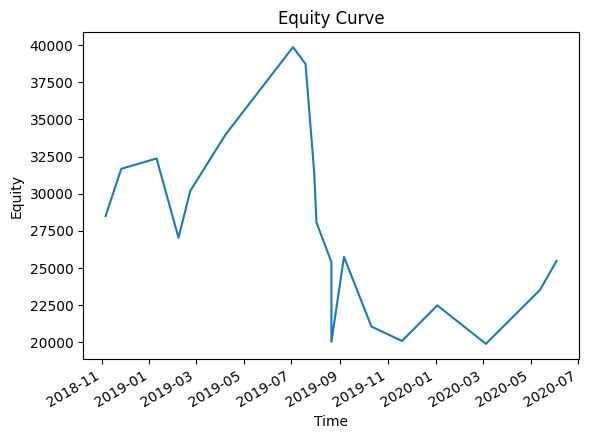

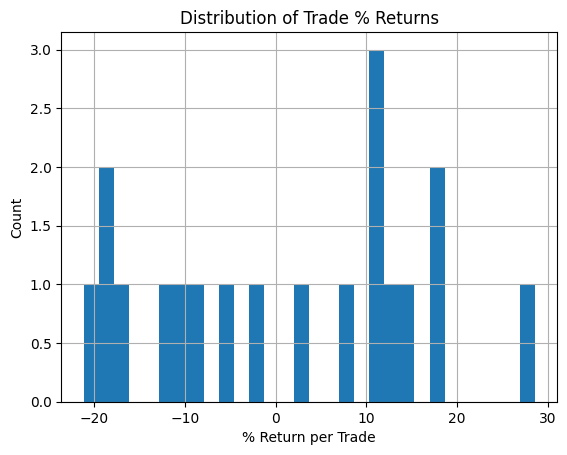

In [11]:
# Equity curve
if not trades_df.empty:
    start_eq = (initial_equity / max(1, len(trades_df['symbol'].unique())))
    eq = [start_eq]
    times = []
    for _, r in trades_df.sort_values('exit_time').iterrows():
        eq.append(eq[-1] * (1 + r['gross_ret_pct']/100.0))
        times.append(r['exit_time'])
    equity_series = pd.Series(eq[1:], index=pd.to_datetime(times))

    plt.figure()
    equity_series.plot()
    plt.title("Equity Curve")
    plt.xlabel("Time")
    plt.ylabel("Equity")
    plt.show()

    plt.figure()
    (trades_df['gross_ret_pct']).hist(bins=30)
    plt.title("Distribution of Trade % Returns")
    plt.xlabel("% Return per Trade")
    plt.ylabel("Count")
    plt.show()

### Notes & Tuning
- **Thresholds** for Morning/Evening Star, Harami, Engulfing, etc., are tunable. See `patterns_df` for exact rules.
- ATR uses Wilder's RMA (`ewm(alpha=1/n)`) on **True Range**.
- Scanner uses the **latest** valid pattern inside `recent_window` across all names, and trend filter is applied **at the signal bar**.
- Backtester enters on the **next bar open** after a signal, assumes **stop first** if stop & target collide on the same bar.
- For intraday (`4h`), consider excluding the still‑forming last bar when scanning/backtesting.
